# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      0.15.0
aiohttp                      3.8.3
aiosignal                    1.2.0
albumentations               1.3.0
anyio                        3.5.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
astor                        0.8.1
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        22.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
blinker                      1.4
brotlipy                     0.7.0
cachetools                   4.2.2
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           2.0.4
clang                        5.0
click                        8.0.4
colorama                     0.4.5
contourpy                    1.0.6
crypt

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')
len(gpus)

1

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
#creating data directory
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
#data klasorundeki happy ve sad klasorlerine tek tek girip tek tek tum fotograflari numpy arrayine cevirir
for image_class in os.listdir(data_dir): #data klasoru icinde haapy veya sad dongusu kurar
    for image in os.listdir(os.path.join(data_dir, image_class)): #happy ve sad klasoru icinde resimler uzerinde dolasir
        image_path = os.path.join(data_dir, image_class, image) 
        try: 
            img = cv2.imread(image_path) #resmi numpy arrayine cevirir
            tip = imghdr.what(image_path) #tur kontrolu ve istenmeyen turdeki resimlerin elimine edilisi
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [8]:
img.shape
#x, y ve rgb kanalarinin matris hali

(855, 570, 3)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export('keras.utils.image_dataset_from_directory',
              'keras.preprocessing.image_dataset_from_directory',
              v1=[])
def image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
               

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data') 
#veriyi uygun formatta yukleme

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()
print(len(batch))#resmin array hali ve classi
print(batch[0].shape) #batchsize=32 imagesize 256,256 rgb=3
print(type(data))
print(type(data_iterator))

2
(32, 256, 256, 3)
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops._NumpyIterator'>


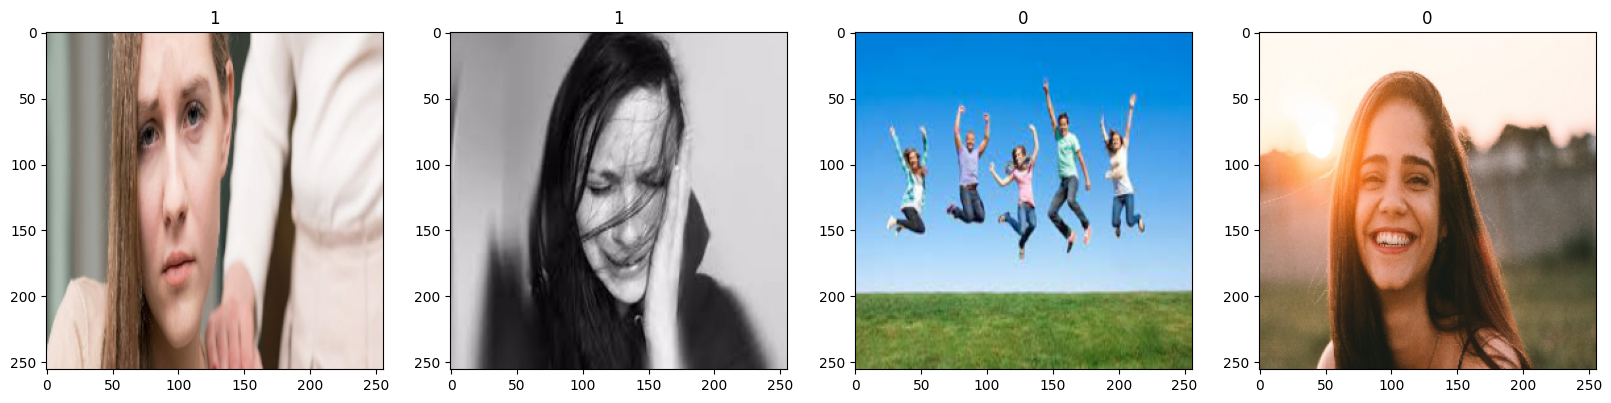

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
#scaled edilmis veriyi islemesi daha kolay ve sonuclari daha keskin olur
#0-256 araliginda olusacak sekilde scale edilimi
data = data.map(lambda x,y: (x/255, y)) #x resimleri y classi temsil eder

In [16]:
data.as_numpy_iterator().next()[0].min()
data.as_numpy_iterator().next()[0].max()

1.0

# 5. Split Data

In [17]:
len(data) 
#10 batch var her biri 32 fotograf iceriyor

10

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size+val_size+test_size

10

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [21]:
print(len(train))
print(len(val))
print(len(test))

7
2
1


# 6. Build Deep Learning Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
#convolutional neural network, 

In [23]:
#tensorflow altyapisinda 2 populer api var. sequantiul ve functional api. 
#kucuk ve basit modeller icin, tek tip inout ve ozellikle tek tip output iceren projelerde
#sequantial api gerek kullanim kolayligi gerek hafiflik nedeniyle tercih edilebilir.
model = Sequential()

In [24]:

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#16 filter (3,3) luk kare matris seklinde 1er adim ilerleyerek goruntu yakaliyor
#relu activation negatif degerleri 0'a donusturen basit ama populer bir aktivasyon yontemi
model.add(MaxPooling2D())
#verideki kritik noktalara odaklanarak boyut azaltmaya ve maliyet dusurmeye odaklanir
#default degeri (2,2) lik bir matristir

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
#32 filter 3e3luk kare matris seklinde 1er adim ilerleyerek goruntu yakaliyor
#relu activation

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
#son CNN katmani

model.add(Flatten())
#olusan parametreleri duzlestirip tek boyuta indirgeme katmani

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#output layer

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 7s 248ms/step - loss: 0.8671 - accuracy: 0.4777 - val_loss: 0.6438 - val_accuracy: 0.6094
Epoch 2/20
7/7 [==============================] - 2s 222ms/step - loss: 0.6106 - accuracy: 0.6518 - val_loss: 0.5380 - val_accuracy: 0.7344
Epoch 3/20
7/7 [==============================] - 2s 182ms/step - loss: 0.6300 - accuracy: 0.6295 - val_loss: 0.5593 - val_accuracy: 0.7031
Epoch 4/20
7/7 [==============================] - 2s 208ms/step - loss: 0.5673 - accuracy: 0.7188 - val_loss: 0.5322 - val_accuracy: 0.8125
Epoch 5/20
7/7 [==============================] - 2s 201ms/step - loss: 0.5099 - accuracy: 0.8214 - val_loss: 0.4620 - val_accuracy: 0.8594
Epoch 6/20
7/7 [==============================] - 2s 191ms/step - loss: 0.4287 - accuracy: 0.7991 - val_loss: 0.3433 - val_accuracy: 0.9219
Epoch 7/20
7/7 [==============================] - 2s 175ms/step - loss: 0.2889 - accuracy: 0.9062 - val_loss: 0.2243 - val_accuracy: 0.9375
Epoch 8/20
7/7 [====

# 8. Plot Performance

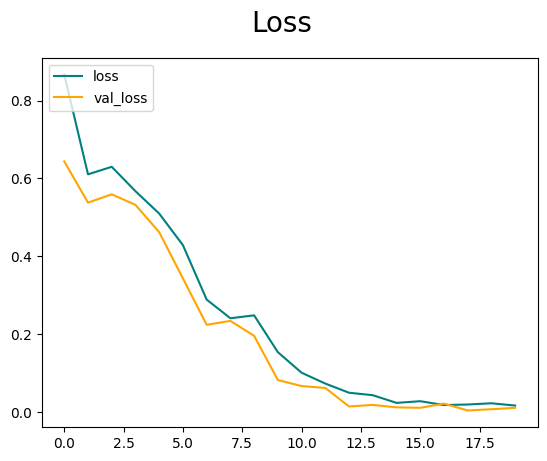

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

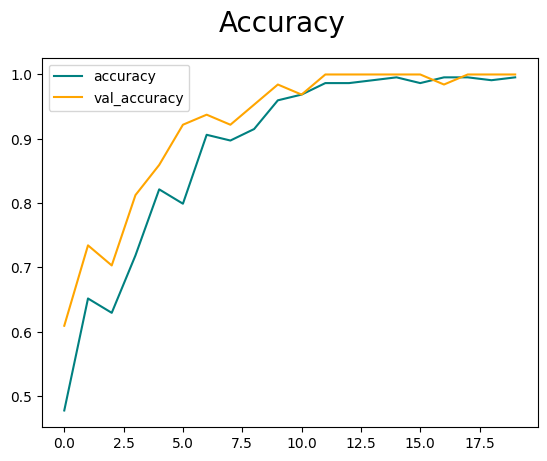

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [35]:
print(f'{pre.result()}, {re.result()}, {acc.result()}')

1.0, 1.0, 1.0


# 10. Test

In [36]:
import cv2

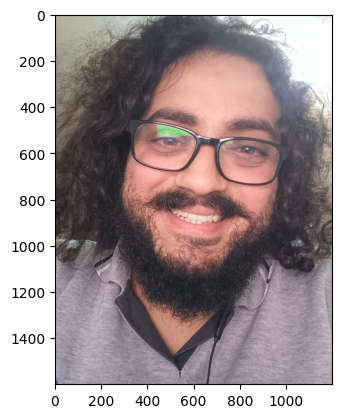

In [37]:
img = cv2.imread('test7.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

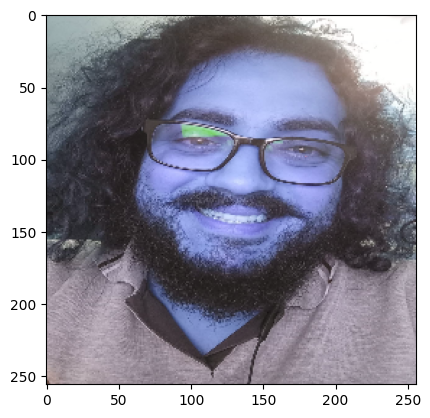

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [40]:
yhat

array([[0.16800122]], dtype=float32)

In [41]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [65]:
from tensorflow.keras.models import load_model

In [66]:
model.save(os.path.join('models','imageclassifierlast.h5'))

In [67]:
new_model = load_model('models\\imageclassifierlast.h5')

In [68]:
a=new_model.predict(np.expand_dims(resize/255, 0))

In [69]:
if a > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
